In [2]:
import os
import glob
import numpy as np
import json
from func import *
from sklearn.metrics import accuracy_score,roc_curve,auc, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [3]:
ai_folder = './data/ai_json(all files)'
gt_folder = './data/review_result_20201012'

ai_path_name = os.listdir(ai_folder) # ['brmh_healthcheck', 'brmh_respiratory', 'gugh_healthcheck', 'gugh_respiratory', 'kyuh_healthcheck', 'kyuh_respiratory']

gt_path_name = [] # ['BRMH_A2', 'BRMH_A1', 'GUGH_A2', 'GUGH_A1', 'KYUH_A2', 'KYUH_A1']

for name in ai_path_name:
    hospital_name = name[:4].upper()
    if 'respiratory' in name:
        seboo = 'A1'
    elif 'healthcheck' in name:
        seboo = 'A2'
    else:
        print('세부 요류')
    gt_path_name.append(hospital_name+'-'+seboo) 

In [4]:
gt_path_name

['BRMH-A2', 'BRMH-A1', 'GUGH-A2', 'GUGH-A1', 'KYUH-A2', 'KYUH-A1']

In [ ]:

for i in range(len(ai_path_name)):
#     if i == 1:
#         break
#     i=0
    print(ai_path_name[i])
    ai_path = os.path.join(ai_folder,ai_path_name[i],'json_output')
    ai_json_li = glob.glob(ai_path+'/*.json')
    
    if 'respiratory' in ai_path_name[i]:
        gt_path = os.path.join(gt_folder,gt_path_name[i],gt_path_name[i][:4],'respiratory')
        gt_json_li = glob.glob(gt_path+'/*.json')
        
    elif 'healthcheck' in ai_path_name[i]:
        gt_path = os.path.join(gt_folder,gt_path_name[i],gt_path_name[i][:4],'healthcheck')
        gt_json_li = glob.glob(gt_path+'/*.json')
    

    
    if len(ai_json_li)!=len(gt_json_li):
        print('list error')
        print(len(ai_json_li),len(gt_json_li))
        break

    gt_label = []
    ai_label = []
    ai_prob = []
    gt_label_nor = []
    ai_label_nor = []
    ai_prob_nor = []

    for ai, gt in zip(ai_json_li,gt_json_li):
        
        if os.path.isfile(ai) and os.path.isfile(gt):

            ############## gt #################
            contours, labels, w, h = json_gt_open(gt)

            if 'Invisible Nodule' in labels:
#                 print(labels)
                if len(labels)==1:
                    gt_label_nor.append(0)
#                     print(0)
                else:
                    gt_label_nor.append(1)
#                     print(1)
            else:
                if contours:
                    gt_label_nor.append(1)
                
                else:
                    gt_label_nor.append(0)
                    

            ############## opt ###############

            prob_map, prob = json_ai_map_open(ai)
            np_map = np.array(prob_map)
            cutoff_mask = cutoff(np_map,0.15)


            if 255 in cutoff_mask:
                ai_label_nor.append(1)
                ai_prob_nor.append(prob)
            else:
                ai_label_nor.append(0)
                ai_prob_nor.append(prob)
    
    cm = confusion_matrix(gt_label_nor,ai_label_nor)
    print(cm)
    print('normal : ', cm[0,0]+cm[0,1])
    print('abnormal : ', cm[1,0]+cm[1,1])
    fp,tp,_=roc_curve(gt_label_nor,ai_prob_nor)
#     print('AUC : ',auc(fp,tp))
    
    # AUC CI
    n_bootstraps = 100
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for m in range(n_bootstraps):
        y_true = np.array(gt_label_nor)
        y_pred = np.array(ai_prob_nor)
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
#             print("Bootstrap #{} ROC area: {:0.3f}".format(m + 1, score))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower_auc = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper_auc = sorted_scores[int(0.975 * len(sorted_scores))]
    print("AUC = {:0.4f} [{:0.3f} - {:0.3}]".format(auc(fp,tp), confidence_lower_auc, confidence_upper_auc))
    
    # acc, sen, spe CI
    sensitivity=[]
    specificity=[]
    acc=[]
    if len(cm) == 2:
        ac=(cm[1,1]+cm[0,0])/(cm[1,0]+cm[1,1]+cm[0,1]+cm[0,0])
        st=cm[1,1]/(cm[1,0]+cm[1,1])
        sp=cm[0,0]/(cm[0,1]+cm[0,0])
        if cm[1,0]+cm[1,1] == 0:
            specificity.append(sp)
            acc.append(ac)
        else:
            sensitivity.append(st)  
            specificity.append(sp)
            acc.append(ac)
    else:
        specificity.append(1)
        acc.append(1)

    
    for m in range(n_bootstraps):
#         y_true = np.array(gt_label)
#         y_pred = np.array(ai_label)
        y_true_nor = np.array(gt_label_nor)
        y_pred_nor = np.array(ai_label_nor)
        
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred_nor), len(y_pred_nor))
        
        if len(np.unique(y_true_nor[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
#         cm1=confusion_matrix(y_true[indices],y_pred[indices])
        cm=confusion_matrix(y_true_nor[indices],y_pred_nor[indices])
#         cm = np.array([[cm2[0,0],cm2[0,1]],[cm1[1,0],cm1[1,1]]])
        
        if len(cm) == 2:
            ac=(cm[1,1]+cm[0,0])/(cm[1,0]+cm[1,1]+cm[0,1]+cm[0,0])
            st=cm[1,1]/(cm[1,0]+cm[1,1])
            sp=cm[0,0]/(cm[0,1]+cm[0,0])
            if cm[1,0]+cm[1,1] == 0:
                specificity.append(sp)
                acc.append(ac)
            else:
                sensitivity.append(st)  
                specificity.append(sp)
                acc.append(ac)
        else:
            specificity.append(1)
            acc.append(1)
            
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    sorted_scores_sn = np.array(sensitivity)
    sorted_scores_sn.sort()
    sorted_scores_sp = np.array(specificity)
    sorted_scores_sp.sort()
    sorted_scores_acc = np.array(acc)
    sorted_scores_acc.sort()
    
    confidence_lower = sorted_scores_sn[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores_sn[int(0.975 * len(sorted_scores))]
    print("sensitivity = {:0.4f} [{:0.3f} - {:0.3f}]".format(sensitivity[0],confidence_lower, confidence_upper))
    
    confidence_lower = sorted_scores_sp[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores_sp[int(0.975 * len(sorted_scores))]
    print("specificity = {:0.4f} [{:0.3f} - {:0.3f}]".format(specificity[0], confidence_lower, confidence_upper))
    
    confidence_lower = sorted_scores_acc[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores_acc[int(0.975 * len(sorted_scores))]
    print("accuracy = {:0.4f} [{:0.3f} - {:0.3f}]".format(acc[0],confidence_lower, confidence_upper))
    
    fp,tp,_=roc_curve(gt_label_nor,ai_prob_nor)
    plt.title(ai_path_name[i])
    lable_txt = 'AUC = {:.4f} [{:0.3f} - {:0.3f}]'.format(round(auc(fp,tp),4), confidence_lower_auc, confidence_upper_auc)
    plt.plot(fp,tp,label=lable_txt)
    plt.xlim([-0.0,1.0])
    plt.ylim([-0.0,1.0])
    plt.xlabel('1-specificity')
    plt.ylabel('sensitivity')
    plt.legend(loc='lower right')
#     plt.savefig('D:/lunit/A1_roc/roc_pneumothorax_'+ai_path_name[i]+'.png')
    plt.show()

kyuh_healthcheck
[[1806  297]
 [   0    1]]
normal :  2103
abnormal :  1
AUC = 0.9970 [0.995 - 0.999]
sensitivity = 1.0000 [1.000 - 1.000]
specificity = 0.8588 [0.837 - 0.879]
accuracy = 0.8588 [0.837 - 0.879]


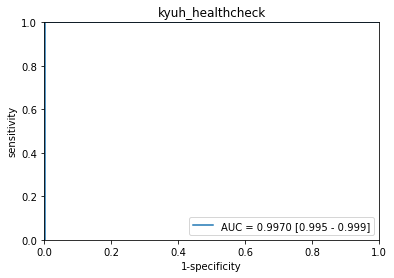

In [11]:

for i in range(len(ai_path_name)):
    if i == 1:
        break
    i=4
    print(ai_path_name[i])
    ai_path = os.path.join(ai_folder,ai_path_name[i],'json_output')
    ai_json_li = glob.glob(ai_path+'/*.json')
    
    if 'respiratory' in ai_path_name[i]:
        gt_path = os.path.join(gt_folder,gt_path_name[i],gt_path_name[i][:4],'respiratory')
        gt_json_li = glob.glob(gt_path+'/*.json')
        
    elif 'healthcheck' in ai_path_name[i]:
        gt_path = os.path.join(gt_folder,gt_path_name[i],gt_path_name[i][:4],'healthcheck')
        gt_json_li = glob.glob(gt_path+'/*.json')
    

    
    if len(ai_json_li)!=len(gt_json_li):
        print('list error')
        print(len(ai_json_li),len(gt_json_li))
        break

    gt_label = []
    ai_label = []
    ai_prob = []
    gt_label_nor = []
    ai_label_nor = []
    ai_prob_nor = []

    for ai, gt in zip(ai_json_li,gt_json_li):
        
        if os.path.isfile(ai) and os.path.isfile(gt):

            ############## gt #################
            contours, labels, w, h = json_gt_open(gt)

            if 'Invisible Nodule' in labels:
#                 print(labels)
                if len(labels)==1:
                    gt_label_nor.append(0)
                    gt_label.append(0)
#                     print(0)
                else:
                    gt_label_nor.append(1)
#                     print(labels)
#                     if 'Nodule / Mass' in labels or 'Consolidation' in labels or 'Pneumothorax' in labels:
#                     if 'Nodule / Mass' in labels:
#                     if 'Consolidation' in labels:
                    if 'Pneumothorax' in labels:
#                         print(labels)
                        gt_label.append(1)
#                         print(1)
                    else:
                        gt_label.append(0)
                
            else:
                if contours:
                    gt_label_nor.append(1)
                
                else:
                    gt_label_nor.append(0)
                    
#                 if 'Nodule / Mass' in labels or 'Consolidation' in labels or 'Pneumothorax' in labels:
#                 if 'Nodule / Mass' in labels:
#                 if 'Consolidation' in labels:
                if 'Pneumothorax' in labels:
#                     print(labels)
                    gt_label.append(1)

                else:              
#                     if not labels:
                    gt_label.append(0)

        ############## ai ###############

        prob_map, prob = json_ai_map_open(ai)
        np_map = np.array(prob_map)
        cutoff_mask = cutoff(np_map,0.15)

        if 255 in cutoff_mask:
            ai_label_nor.append(1)
            ai_prob_nor.append(prob)
        else:
            ai_label_nor.append(0)
            ai_prob_nor.append(prob)

#         if 'Nodule / Mass' in labels or 'Consolidation' in labels or 'Pneumothorax' in labels:
#         if 'Nodule / Mass' in labels:
#         if 'Consolidation' in labels:
        if 'Pneumothorax' in labels:
            if 255 in cutoff_mask:
                ai_label.append(1)
                ai_prob.append(prob)
            else:
                ai_label.append(0)
                ai_prob.append(prob)
        else:
    #                 if not labels:
            ai_label.append(0)
            ai_prob.append(prob)

    cm1 = confusion_matrix(gt_label,ai_label)
    cm2 = confusion_matrix(gt_label_nor,ai_label_nor)
    cm = np.array([[cm2[0,0],cm2[0,1]],[cm1[1,0],cm1[1,1]]])
    print(cm)
    print('normal : ', cm[0,0]+cm[0,1])
    print('abnormal : ', cm[1,0]+cm[1,1])
    fp,tp,_=roc_curve(gt_label,ai_prob)
#     print('AUC : ',auc(fp,tp))
    
    # AUC CI
    n_bootstraps = 100
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for m in range(n_bootstraps):
        y_true = np.array(gt_label)
        y_pred = np.array(ai_prob)
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
#             print("Bootstrap #{} ROC area: {:0.3f}".format(m + 1, score))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower_auc = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper_auc = sorted_scores[int(0.975 * len(sorted_scores))]
    print("AUC = {:0.4f} [{:0.3f} - {:0.3}]".format(auc(fp,tp), confidence_lower_auc, confidence_upper_auc))
    
    # acc, sen, spe CI
    sensitivity=[]
    specificity=[]
    acc=[]
    if len(cm) == 2:
        ac=(cm[1,1]+cm[0,0])/(cm[1,0]+cm[1,1]+cm[0,1]+cm[0,0])
        st=cm[1,1]/(cm[1,0]+cm[1,1])
        sp=cm[0,0]/(cm[0,1]+cm[0,0])
        if cm[1,0]+cm[1,1] == 0:
            specificity.append(sp)
            acc.append(ac)
        else:
            sensitivity.append(st)  
            specificity.append(sp)
            acc.append(ac)
    else:
        specificity.append(1)
        acc.append(1)

    
    for m in range(n_bootstraps):
        y_true = np.array(gt_label)
        y_pred = np.array(ai_label)
        y_true_nor = np.array(gt_label_nor)
        y_pred_nor = np.array(ai_label_nor)
        
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        cm1=confusion_matrix(y_true[indices],y_pred[indices])
        cm2=confusion_matrix(y_true_nor[indices],y_pred_nor[indices])
        cm = np.array([[cm2[0,0],cm2[0,1]],[cm1[1,0],cm1[1,1]]])
        
        if len(cm) == 2:
            ac=(cm[1,1]+cm[0,0])/(cm[1,0]+cm[1,1]+cm[0,1]+cm[0,0])
            st=cm[1,1]/(cm[1,0]+cm[1,1])
            sp=cm[0,0]/(cm[0,1]+cm[0,0])
            if cm[1,0]+cm[1,1] == 0:
                specificity.append(sp)
                acc.append(ac)
            else:
                sensitivity.append(st)  
                specificity.append(sp)
                acc.append(ac)
        else:
            specificity.append(1)
            acc.append(1)
            
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    sorted_scores_sn = np.array(sensitivity)
    sorted_scores_sn.sort()
    sorted_scores_sp = np.array(specificity)
    sorted_scores_sp.sort()
    sorted_scores_acc = np.array(acc)
    sorted_scores_acc.sort()
    
    confidence_lower = sorted_scores_sn[int(0.025 * len(sorted_scores_sn))]
    confidence_upper = sorted_scores_sn[int(0.975 * len(sorted_scores_sn))]
    print("sensitivity = {:0.4f} [{:0.3f} - {:0.3f}]".format(sensitivity[0],confidence_lower, confidence_upper))
    
    confidence_lower = sorted_scores_sp[int(0.025 * len(sorted_scores_sp))]
    confidence_upper = sorted_scores_sp[int(0.975 * len(sorted_scores_sp))]
    print("specificity = {:0.4f} [{:0.3f} - {:0.3f}]".format(specificity[0], confidence_lower, confidence_upper))
    
    confidence_lower = sorted_scores_acc[int(0.025 * len(sorted_scores_acc))]
    confidence_upper = sorted_scores_acc[int(0.975 * len(sorted_scores_acc))]
    print("accuracy = {:0.4f} [{:0.3f} - {:0.3f}]".format(acc[0],confidence_lower, confidence_upper))
    
    fp,tp,_=roc_curve(gt_label,ai_prob)
    plt.title(ai_path_name[i])
    lable_txt = 'AUC = {:.4f} [{:0.3f} - {:0.3f}]'.format(round(auc(fp,tp),4), confidence_lower_auc, confidence_upper_auc)
    plt.plot(fp,tp,label=lable_txt)
    plt.xlim([-0.0,1.0])
    plt.ylim([-0.0,1.0])
    plt.xlabel('1-specificity')
    plt.ylabel('sensitivity')
    plt.legend(loc='lower right')
#     plt.savefig('D:/lunit/A1_roc/roc_pneumothorax_'+ai_path_name[i]+'.png')
    plt.show()